In this notebook we will look at a method for designing a screening library for use with Size Exclusion Chromatography Mass Spectrometry (SEC-MS).  In this technique, we screen mixtures of compounds, since the final readout is mass, we want to have mixtures that have diverse masses. 

Import the necessary Python libraries

In [18]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

Define a few constants
* resolution - the presumed mass difference that can be detected by the mass spectrometer
* max_min - we will consider different mixture sizes, the minimimium size considered will be 100
* mix_max - maximum mixture size
* mix_inc - amout to increment the mixture size, we will consider sizes between 100 and 1600 incremented by 100.  So we will look at mixtures of size 100, 200, 300, 400 ... 1400, 1500, 1600


In [19]:
resolution = 1
mix_min = 100
mix_max = 1600
mix_inc = 100

Read in our data that indicates the molecules id, the identifier for the 384 well plate, and the molecular weight for the molecule.

In [20]:
df = pd.read_csv("../data/plates.csv")

Look at the first few lines of the dataframe.

In [21]:
df.head()

,NAME,PLATE,MW
0,MOL00000001,PLATE00000001,333.77
1,MOL00000002,PLATE00000001,334.39
2,MOL00000003,PLATE00000001,355.50
3,MOL00000004,PLATE00000001,399.41
4,MOL00000005,PLATE00000001,322.29


Sort the dataframe by molecular weight

In [22]:
df.sort_values("MW",inplace=True)

Get the number of molecules in the dataframe

In [23]:
num_rows = df.shape[0]
num_rows

99532

Assign new column to the dataframe showing the position of each molecule when ordered by molecular weight

In [24]:
df['row_idx'] = range(0,num_rows)

In [25]:
df.head()

,NAME,PLATE,MW,row_idx
82237,MOL00082238,PLATE00000215,174.63,0
58935,MOL00058936,PLATE00000155,177.63,1
87261,MOL00087262,PLATE00000229,187.67,2
67634,MOL00067635,PLATE00000177,199.08,3
52603,MOL00052604,PLATE00000138,201.22,4


OK, now for the fun part, we're going to design mixtures with diverse masses.  Now that we have the molecules ordered by mass, it's trivial to divide this into mixtures.  We can simply select every nth row, where n is the total number of molecules / the total number of mixtures.  For instance if we have 100 molecules and we have a total of 10 mixtures, we would select every 10th row.  We can get the mixture number by taking the modulus "%" of the row index by the number of mixtures. 

The code below calculates the number of unique masses in each mixture.  Since we are generating mulitple mixtures, we report both the minimum and median number of unique masses. 

In [26]:
summary_list = []
for mixture_size in range(mix_min,mix_max+1,mix_inc):
    num_mixtures = num_rows//mixture_size + 1
    print(mixture_size,num_mixtures,"mixtures")
    df['mixture'] = df['row_idx'] % num_mixtures
    unique_mass_list = []
    for k,v in df.groupby('mixture'):
        mw_vals = v['MW'].to_list()
        unique_mass_list.append(len(set([int(x*1/resolution) for x in mw_vals])))
    summary_list.append([mixture_size,np.min(unique_mass_list),np.median(unique_mass_list)])

100 996 mixtures
200 498 mixtures
300 332 mixtures
400 249 mixtures
500 200 mixtures
600 166 mixtures
700 143 mixtures
800 125 mixtures
900 111 mixtures
1000 100 mixtures
1100 91 mixtures
1200 83 mixtures
1300 77 mixtures
1400 72 mixtures
1500 67 mixtures
1600 63 mixtures


Take the result of the function above and put it into a a dataframe. 

In [27]:
col_list = ["Size","Min","Median"]
col_list = [x + "_Opt" for x in col_list]
df_opt = pd.DataFrame(summary_list,columns=col_list)

In [28]:
df_opt

,Size_Opt,Min_Opt,Median_Opt
0,100,99,100.0
1,200,147,148.0
2,300,170,172.0
3,400,184,186.0
4,500,189,192.0
5,600,193,197.0
6,700,196,199.0
7,800,199,200.0
8,900,198,201.0
9,1000,200,201.0


The code above allowed us to design a library with mixtures having diverse masses.  Of course, replating our screening collection is going to be a lot of work.  Let's look at what would happen if we did nothing and simply designed mixtures based on the existing plate layout. 

We can simlate this by sorting the library first by plate, then by molecular weight.

In [29]:
df.sort_values(["PLATE","MW"],inplace=True)
df['row_idx'] = range(0,num_rows)

Now we can follow the same mixture desig protocol we used above.  I probably should have broken this out into a function rather than simply copying and pasting the code. 

In [30]:
summary_list = []
for mixture_size in range(mix_min,mix_max+1,mix_inc):
    num_mixtures = num_rows//mixture_size + 1
    print(mixture_size,num_mixtures,"mixtures")
    df['mixture'] = df['row_idx'] % num_mixtures
    unique_mass_list = []
    for k,v in df.groupby('mixture'):
        mw_vals = v['MW'].to_list()
        unique_mass_list.append(len(set([int(x*1/resolution) for x in mw_vals])))
    summary_list.append([mixture_size,np.min(unique_mass_list),np.median(unique_mass_list)])

100 996 mixtures
200 498 mixtures
300 332 mixtures
400 249 mixtures
500 200 mixtures
600 166 mixtures
700 143 mixtures
800 125 mixtures
900 111 mixtures
1000 100 mixtures
1100 91 mixtures
1200 83 mixtures
1300 77 mixtures
1400 72 mixtures
1500 67 mixtures
1600 63 mixtures


Again, we'll take the output from the code above and create a dataframe.  Note that this time the dataframe has a different name and the columns are named differently. 

In [31]:
col_list = ["Size","Min","Median"]
col_list = [x + "_Plate" for x in col_list]
df_plate = pd.DataFrame(summary_list,columns=col_list)

Our next task will be to create a plot comparing the two different approaches to library design (optimal and plate based).  In order to do this, we need to massage the data a bit.  First we will combine the two dataframes we created above. 

In [40]:
combo_df = pd.concat([df_opt,df_plate],axis=1)
combo_df

,Size_Opt,Min_Opt,Median_Opt,Size_Plate,Min_Plate,Median_Plate
0,100,99,100.0,100,66,75.0
1,200,147,148.0,200,106,117.0
2,300,170,172.0,300,129,141.5
3,400,184,186.0,400,146,156.0
4,500,189,192.0,500,157,167.0
5,600,193,197.0,600,163,175.0
6,700,196,199.0,700,171,179.0
7,800,199,200.0,800,176,184.0
8,900,198,201.0,900,180,187.0
9,1000,200,201.0,1000,184,190.0


We now need to reshape this dataframe so that we have new dataframe with the mixture size, median number of unqiue molecules per mixture and an indicator variable showing the approach.  Fortunately, the "melt" method in Pandas makes it easy to do this. 

In [41]:
melt_df = combo_df[["Size_Opt","Min_Opt","Min_Plate"]].melt(id_vars="Size_Opt")
melt_df

,Size_Opt,variable,value
0,100,Min_Opt,99
1,200,Min_Opt,147
2,300,Min_Opt,170
3,400,Min_Opt,184
4,500,Min_Opt,189
5,600,Min_Opt,193
6,700,Min_Opt,196
7,800,Min_Opt,199
8,900,Min_Opt,198
9,1000,Min_Opt,200


Now that we've reformatted the data, we can make our plot.    

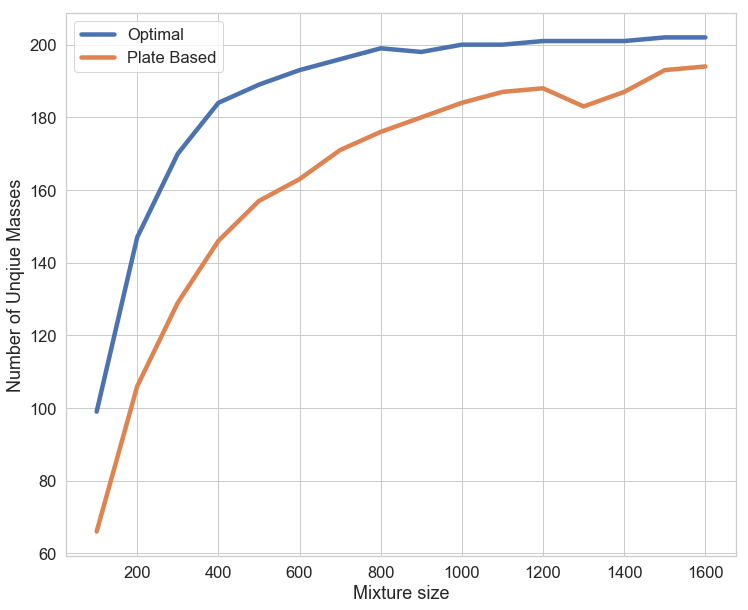

In [38]:
sns.set(rc={'figure.figsize': (12, 10)})
sns.set(font_scale=1.5,rc={"lines.linewidth": 4.5})
sns.set_style('whitegrid')
ax = sns.lineplot(x=melt_df.Size_Opt,y=melt_df.value,hue=melt_df.variable)
ax.set(xlabel="Mixture size",ylabel="Number of Unqiue Masses")
_ = plt.legend(title="",loc="best",labels=['Optimal', 'Plate Based'])

It's interesting to note that the differences aren't very large.  With a mixture size of 800, the optimal approach gives us ~200 unqiue masses per mixture, while the plate based approach gives us 175 unque masses per mixture. 

The plot above is informative, but it doesn't really get at the crical question, which is the number of molecules we would need to test if found a hit with a specific mass. For instance, if we found a hit with mass 425 we would want to test every molecule with mass between 424 and 426 (assuming a resolution of 1 AMU).  Fortunately, it's easy to get at this value all we have to do is divide the number of molecules in the mixture by the number of unique masses. 

In [20]:
combo_df['Opt_Search'] = combo_df['Size_Opt']/combo_df['Min_Opt']
combo_df['Plate_Search'] = combo_df['Size_Plate']/combo_df['Min_Plate']

We can now use a procedure similar to the one we used above to combine and melt the dataframes and generate the plot. Again, the differences are small. For a mixture size of 800, we would have to test 4 compounds per hit with the optimzal approach.  For the plate based approach we would have to test 5 compounds (we can't test 4.5 compounds).  

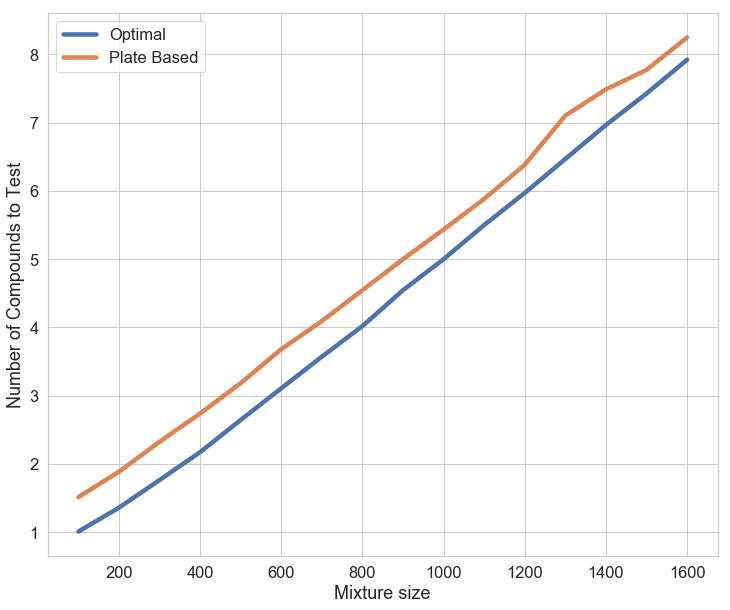

In [21]:
melt_df = combo_df[["Size_Opt","Opt_Search","Plate_Search"]].melt(id_vars="Size_Opt")
ax = sns.lineplot(x=melt_df.Size_Opt,y=melt_df.value,hue=melt_df.variable)
ax.set(xlabel="Mixture size",ylabel="Number of Compounds to Test")
_ = plt.legend(title="",loc="best",labels=['Optimal', 'Plate Based'])

Go back to the top of this notebook, change the resolution to 0.1 and see how this impacts the results. 